#Playing Space invaders with Proximal Policy Optimization (PPO) algorithm

In this notebook I will train an agent using an actor-critic [PPO algorithm](https://arxiv.org/pdf/1707.06347.pdf)  to play the Atari 2600 game MsPacman using the reinforcement learning library [TF-Agents](https://www.tensorflow.org/agents). <br> Using the [OpenAI Gym environment](https://gym.openai.com/envs/SpaceInvaders-ram-v0/),  the agent can be trained using as a input the RAM of the Atari machine consisting of 128 bytes. 

In [ ]:
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'imageio==2.4.0'
! pip install tf-agents==0.7.1 #last version seem to have some problems
!pip install atari-py
!python -m atari_py.import_roms "/content/drive/MyDrive/Reinforcement learning/PPO/space invaders" #import downloaded ROMs of the game

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 2s (419 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected pack

##Install and import dependencies

In [ ]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import os
import tempfile
import PIL.Image
import time
import csv

import tensorflow as tf

import tf_agents
from tf_agents.utils import common
from tf_agents.environments import suite_gym
from tf_agents.environments import suite_atari
from tf_agents.environments import tf_py_environment
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils
from tf_agents.networks.value_network import ValueNetwork
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.agents.ppo.ppo_clip_agent import PPOClipAgent
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment
import numpy as np


##Hyperparameters

I use the Generalized Advantage Estimator (GAE) to compute the advantage over 100 temporal difference steps with a relatively large $\lambda=0.95$ and I also use a large discount factor $\gamma=0.995$ to make the agent consider properly long terms rewards. This because in the Space Invader game there can be quite some steps between an action (e.g. shooting) and the moment the reward due to that action (e.g. the projectile hits a spaceship) is awarded. \\
The PPO algorithm is implemented by a clipped surrogate objective with clipping $\epsilon=0.1$. \\
The agent collects 10 episodes every iteration and performs only one gradient descent steps per batch (`batch size=64`). 

In [ ]:
continue_training=True
use_GPU=False 
use_TPU=False

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_GPU)
#agent hyperparameters
learning_rate = 1e-4
gamma = 0.995
surrogate_objective_clipping=0.1
lambda_value=0.95 #TD lambda returns for GAE
num_epochs_policy_update=3 #Number of epochs between policy updates 
reward_norm_clipping=15
entropy_regularization=3e-3
actor_fc_layer_params = (512,512,512,512) 
value_fc_layer_params = (512,512,512,512) 
dropout_layer_params=(0.2,0.2,0.2,0.2) #for both value and actor nets
gradient_clipping=1.
value_clipping=None
batch_size=64
TD_steps=100 #TD steps for GAE estimation

#Training loop 
num_iterations = 200
collect_episodes_per_iteration=10 #it may be useful to start low and increase it in training
replay_buffer_capacity =10000  #This must change depending how many episodes per iteration we are using, order 1000 steps per episode
checkpoint_iterations=36
eval_interval=50
video_saving_interval=10000*num_epochs_policy_update
num_eval_episodes = 10
log_interval=5


## Environment setup

I use the RAM gym environment: https://gym.openai.com/envs/SpaceInvaders-ram-v0. \\
 The input of the agent will thus be directly the 128 byte of the atari machine. This poses several challenges with respect to using the visual of the screen as an input as the information in the RAM can be encoded in a complicated way. In particulare there are no simple "geometric" features that we can exploit with a CNN architecture to determine the positions of enemy spaceships or of the projectiles falling. \\
The environment also repeat each action taken by the agent for a random number of frames in the range {2,3,4} thus effectively introducing stochasticity in the environment and making learning more challenging. \\
A further challenge posed by this environments is that the episode ends when the agent loses all 3 lives, this makes episodes longer than just considering each life separatly because the agent must consider longer term rewards. In particular after having lost one life there is no penalty and the agent can continue to collect points (unless it was the last life), making more difficult for the agent to learn to avoid being hit.

In [ ]:
env_name ="SpaceInvaders-ram-v0"         #The state will be specified directly by the 128 byte RAM of the atari machine
env = suite_gym.load(env_name)
env.reset()
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Reward Spec:')
print(env.time_step_spec().reward)
print('Action Spec:')
print(env.action_spec())
print('Reward spec')

#Defining train and evaluation environment and wrapping them into a TF environment
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)
#Distribution strategy
observation_spec, action_spec, time_step_spec = (spec_utils.get_tensor_specs(train_env))
print('Time step spec:', time_step_spec, 'action_spec', action_spec)

norm_observation_spec = tf.nest.map_structure(lambda s: tf.TensorSpec(dtype=tf.float32, shape=s.shape, name=s.name),observation_spec)
print('Norm spec:',norm_observation_spec)


Observation Spec:
BoundedArraySpec(shape=(128,), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)
Reward spec
Time step spec: TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(128,), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8))) action_spec BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(5))
Norm spec: TensorSpec(shape=(128,), dtype=tf.float32, name='observation')


##Agent and networks

I use two identical networks made up by 4 hidden layers with 512 neurons each and 0,2 dropout rate for both the actor and the critic.

In [ ]:
activation=tf.keras.layers.ELU(alpha=0.1)

#value network for advantage estimation
value_net=ValueNetwork(
      norm_observation_spec,
      fc_layer_params=value_fc_layer_params, 
      dropout_layer_params=dropout_layer_params,
      activation_fn=activation,

      name='ValueNetwork')
#actor network  
actor_net=ActorDistributionNetwork(
      norm_observation_spec,
      train_env.action_spec(),
      dropout_layer_params= dropout_layer_params,
      fc_layer_params=actor_fc_layer_params,
      activation_fn=activation,
      name='ActorNetwork'
      )

train_step = train_utils.create_train_step()
train_step_counter = tf.Variable(0, dtype='int64')

PPO_agent = PPOClipAgent(
    time_step_spec,
    train_env.action_spec(),
    optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate),
    actor_net= actor_net,
    value_net= value_net,
    importance_ratio_clipping= surrogate_objective_clipping,
    lambda_value= lambda_value,
    discount_factor=gamma,
    num_epochs= num_epochs_policy_update,
    use_gae=True,
    use_td_lambda_return =True,
    normalize_rewards= True,
    reward_norm_clipping = reward_norm_clipping,
    normalize_observations = True,
    train_step_counter= train_step_counter,
    entropy_regularization=entropy_regularization,
    gradient_clipping=gradient_clipping,
    )

PPO_agent.initialize() 


#Policies
tf_eval_policy = PPO_agent.policy #Deterministic policy, always picks the action with highest probability
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(tf_eval_policy, use_tf_function=True)
tf_collect_policy =PPO_agent.collect_policy #probabilistic policy, sample action according to their probabilities
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(tf_collect_policy, use_tf_function=True)
random_policy = random_py_policy.RandomPyPolicy(train_env.time_step_spec(), train_env.action_spec())

##Replay buffer, collect driver and checkpointer

In [ ]:
replay_buffer = TFUniformReplayBuffer(PPO_agent.collect_data_spec, batch_size=train_env.batch_size, max_length=replay_buffer_capacity)

#Collect driver to collect episodes given the current policy
collect_driver = dynamic_episode_driver.DynamicEpisodeDriver(train_env, collect_policy, observers=[replay_buffer.add_batch],
                                                             num_episodes=collect_episodes_per_iteration)

checkpoint_dir = '/content/drive/MyDrive/Reinforcement learning/PPO/' 

#Wrap collected trajectories into a tf dataset
dataset = replay_buffer.as_dataset(
      num_steps=TD_steps,
      sample_batch_size=batch_size, 
      #single_deterministic_pass=True,
    ).prefetch(3)
iterator=iter(dataset)
experience_dataset_fn = lambda: dataset

#Learner class of tf-agent takes care of most part of training process, including training steps and saving checkpointer
learner=tf_agents.train.Learner(
    checkpoint_dir, train_step_counter, PPO_agent, experience_dataset_fn=experience_dataset_fn,
    checkpoint_interval=500, summary_interval=1000, max_checkpoints_to_keep=2
    )

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Instructions for updating:
rename to distribute_datasets_from_function


##Evaluation and visualization utilities

In [ ]:
def return_and_lenght_mean_std(environment, policy, num_episodes=10):
  """ Given a policy collects episodes and compute mean and standard deviation for both
  rewards and episode's lenght"""
  returns =[]
  lenght=[]
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    n_steps=0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
      n_steps+=1
    returns.append(episode_return.numpy()[0])
    lenght.append(n_steps)
  mean_return=np.mean(returns)
  returns_std=np.std(returns)
  mean_lenght=np.mean(lenght)
  lenght_std=np.std(lenght)
  return mean_return, returns_std, mean_lenght, lenght_std

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = ''' 
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())
 
  return IPython.display.HTML(tag)
 

def create_policy_eval_video(policy, filename, num_episodes=3, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename) 

def return_histo(environment, policy, num_episodes=100):

    returns =[]
    lenght=[]
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0
      n_steps=0
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
        n_steps+=1
      returns.append(episode_return.numpy()[0])
      lenght.append(n_steps)
      
    mean_return=np.mean(returns)
    returns_std=np.std(returns)
    mean_lenght=np.mean(lenght)
    lenght_std=np.std(lenght)
    print("Mean return:", mean_return,"Standard deviation:", returns_std)
    print("Mean lenght:", mean_lenght,"Standard deviation:", lenght_std)
    print('returns', returns)  

    plt.hist(returns, bins='auto')
    plt.show()

    print('Steps per episode')
    plt.hist(lenght, bins='auto')
    plt.show()

##Visualize behavior of a random agent

Visualizing behavior and performance of an agent acting randomly. Comparing with this helps understanding how much the agent is learning during training. 

In [ ]:
#create_policy_eval_video(random_policy, 'random_agent', num_episodes=3)

##Training loop

In [ ]:
start_time = time.time()

for counter in range(num_iterations):
    collect_driver.run() #collect new episodes
    #print(replay_buffer.num_frames())
    train_loss =learner.run(iterations=1)
    replay_buffer.clear() #delete used episodes from the buffer

    #Log losses 
    if counter % log_interval == 0:     
      current_time=time.time()
      elapsed_time=current_time-start_time
      step = PPO_agent.train_step_counter.numpy()
      ETA=(num_iterations-counter+1)/((counter+1)/elapsed_time)
      print('Elapsed time={0}:{1}:{2}, ETA={3}:{4}:{5}; step = {6}, PPO_loss = {7}, Value extimation loss={8}, Entropy reg loss={9}'.format(int(elapsed_time//3600),
                                                    int((elapsed_time % 3600)//60), int(elapsed_time % 60), int(ETA//3600),
                                                    int((ETA % 3600)//60), int(ETA % 60), step, train_loss[1][0].numpy(),train_loss[1][1].numpy(),train_loss[1][3].numpy() ))

    #Show evaluation metrics and append them to the csv 
    if counter % eval_interval==0:   
      mean_return, returns_std, mean_lenght, lenght_std= return_and_lenght_mean_std(eval_env, PPO_agent.collect_policy, num_episodes=num_eval_episodes)
      print('Average return:', mean_return, ' Standard deviation:', returns_std,'\n Mean lenght:', mean_lenght, 'Standard deviation:', lenght_std)   
      with open('/content/drive/MyDrive/Reinforcement learning/PPO/log.csv', mode='a') as log:
          log_writer = csv.writer(log, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
          log_writer.writerow([step,mean_return, returns_std, mean_lenght, lenght_std])


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Elapsed time=0:1:29, ETA=4:59:0; step = 102648, PPO_loss = 0.019663413986563683, Value extimation loss=0.6062865257263184, Entropy reg loss=-0.002046778332442045
Average return: 802.0  Standard deviation: 167.4246 
 Mean lenght: 1297.4 Standard deviation: 319.31526740824654
Elapsed time=0:9:58, ETA=5:25:40; step = 102663, PPO_loss = 0.01288006454706192, Value extimation loss=1.0525270700454712, Entropy reg loss=-0.0018844002624973655
Elapsed time=0:16:16, ETA=4:42:31; step = 102678, PPO_loss = 0.003906087949872017, Value extimation loss=0.9602804780006409, Entropy reg loss=-0.00215966091491282
Elapsed time=0:22:21, ETA=4:19:51; step = 102693, PPO_loss = 0.01553274691104889, Value extimation loss=1.0395251512527466, Entropy reg loss=-0.0021456624381244183
Elapsed time=0:28:28, ETA=4:5:24; step = 102708, PPO_loss = 0.008682908490300179, Value extimation loss=0.6734017133712769, Entropy reg loss=-0.0021616502199321985
Elapsed time=0:34:26, ETA=3:53:7; step = 102723, PPO_loss = 0.007183492

##Evaluation and visualization of the results

Let's visualize the history of agent's performance.


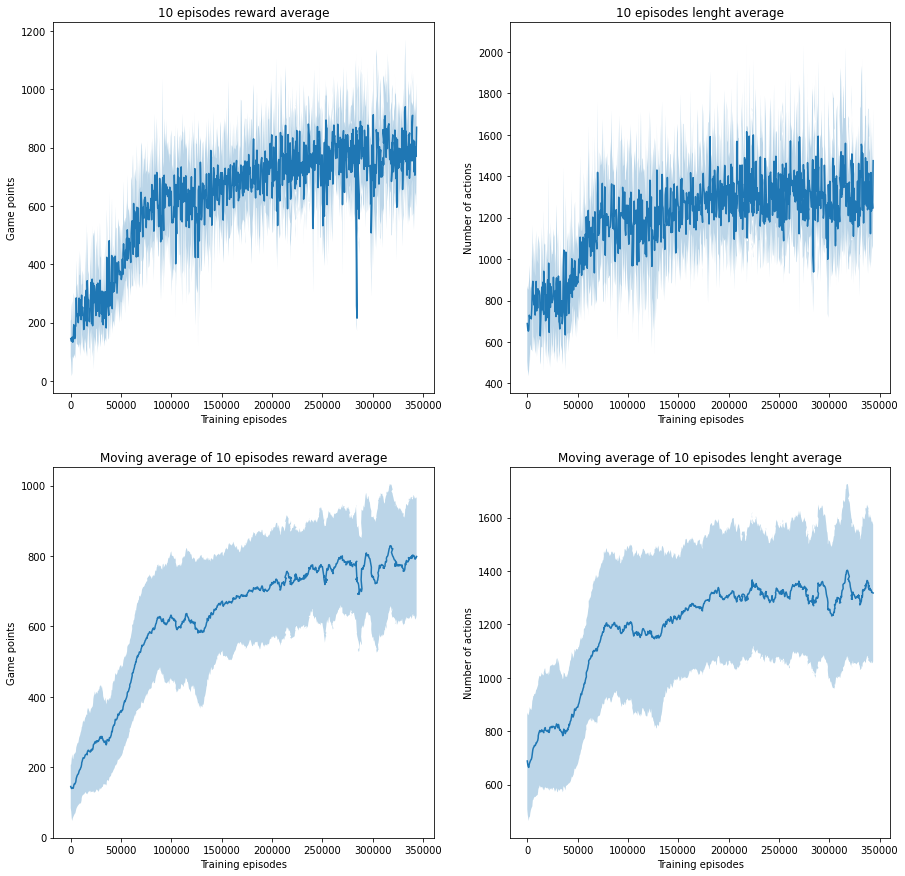

In [ ]:
def moving_average(array, steps):
    moving_avg=np.empty(array.shape)
    for i in range(array.shape[0]):
        if i<steps:
          history=array[0:(i+1)]
          moving_avg[i]=np.mean(history)
        else:
          history=array[i-steps:(i+1)]   
          moving_avg[i]=np.mean(history)
    return moving_avg


with open('//content/drive/MyDrive/Reinforcement learning/PPO/log.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    step_number=[]
    reward_avg=[]
    reward_std=[]
    lenght_avg=[]
    lenght_std=[]

    for row in csv_reader:
      step_number.append(float(row[0]))
      reward_avg.append(float(row[1]))
      reward_std.append(float(row[2]))
      lenght_avg.append(float(row[3]))
      lenght_std.append(float(row[4]))
reward_avg=np.asarray(reward_avg)
reward_std=np.asarray(reward_std)
lenght_avg=np.asarray(lenght_avg)
lenght_std=np.asarray(lenght_std)
step_number=np.asarray(step_number)

moving_steps=20
moving_reward_avg=moving_average(reward_avg,moving_steps)
moving_reward_std=moving_average(reward_std,moving_steps)
moving_lenght_avg=moving_average(lenght_avg,moving_steps)
moving_lenght_std=moving_average(lenght_std,moving_steps)

collected_episodes=(step_number/num_epochs_policy_update)*collect_episodes_per_iteration
fig, axs=plt.subplots(2,2, figsize=(15,15))
axs[0,0].plot(collected_episodes,reward_avg)
axs[0,0].fill_between(collected_episodes, reward_avg-reward_std, reward_avg+reward_std, alpha=0.3)
axs[0,0].set_ylabel('Game points')
axs[0,0].set_xlabel('Training episodes')
axs[0,0].set_title('{} episodes reward average'.format(num_eval_episodes))
axs[0,1].plot(collected_episodes,lenght_avg)
axs[0,1].fill_between(collected_episodes, lenght_avg-lenght_std, lenght_avg+lenght_std, alpha=0.3)
axs[0,1].set_ylabel('Number of actions')
axs[0,1].set_xlabel('Training episodes')
axs[0,1].set_title('{} episodes lenght average'.format(num_eval_episodes))
axs[1,0].plot(collected_episodes,moving_reward_avg)
axs[1,0].fill_between(collected_episodes, moving_reward_avg-moving_reward_std, moving_reward_avg+moving_reward_std, alpha=0.3)
axs[1,0].set_ylabel('Game points')
axs[1,0].set_xlabel('Training episodes')
axs[1,0].set_title('Moving average of {} episodes reward average'.format(num_eval_episodes))
axs[1,1].plot(collected_episodes, moving_lenght_avg)
axs[1,1].fill_between(collected_episodes, moving_lenght_avg-moving_lenght_std, moving_lenght_avg+moving_lenght_std, alpha=0.3)
axs[1,1].set_ylabel('Number of actions')
axs[1,1].set_xlabel('Training episodes')
axs[1,1].set_title('Moving average of {} episodes lenght average'.format(num_eval_episodes))
plt.show()


Figure above: Plots of average 20 episodes reward and lenght and relative moving average. Shadowed areas show region included in average $\pm $ standar deviation and, respectively, moving average $\pm$ moving standard deviation.

Let's visualize the performance of the policy acting by sampling from the respective probabilities

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = ''' 
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())
 
  return IPython.display.HTML(tag)
 
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=30) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = collect_policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())
 
embed_mp4(video_filename)

We observe that the agent is able to easily solve the first level, but it seems to be stuck at the second level. This may be due to the fact that, despite visually the two levels are extremely similar, the information encoded in the RAM can be quite different and thus the agent has to learn this difference before being able to play effectively.

Reward and episode lenght histograms 

Mean return: 813.05 Standard deviation: 141.4141
Mean lenght: 1342.22 Standard deviation: 293.14271541349956
returns [755.0, 1040.0, 1010.0, 770.0, 910.0, 915.0, 765.0, 805.0, 605.0, 800.0, 800.0, 805.0, 780.0, 770.0, 785.0, 940.0, 775.0, 940.0, 805.0, 730.0, 805.0, 745.0, 390.0, 905.0, 805.0, 785.0, 810.0, 800.0, 680.0, 805.0, 1240.0, 800.0, 805.0, 695.0, 800.0, 1120.0, 805.0, 580.0, 805.0, 935.0, 800.0, 810.0, 840.0, 800.0, 695.0, 810.0, 1120.0, 1010.0, 780.0, 800.0, 800.0, 435.0, 695.0, 810.0, 1240.0, 800.0, 600.0, 910.0, 940.0, 520.0, 770.0, 840.0, 600.0, 880.0, 740.0, 840.0, 790.0, 730.0, 905.0, 940.0, 1040.0, 1040.0, 905.0, 510.0, 745.0, 770.0, 1040.0, 770.0, 720.0, 940.0, 1040.0, 785.0, 740.0, 785.0, 800.0, 540.0, 905.0, 740.0, 800.0, 750.0, 800.0, 675.0, 805.0, 780.0, 810.0, 905.0, 810.0, 800.0, 750.0, 935.0]


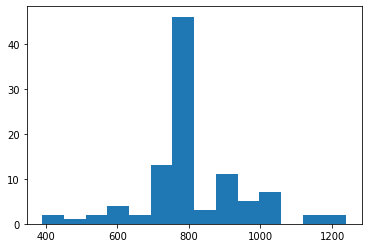

Steps per episode


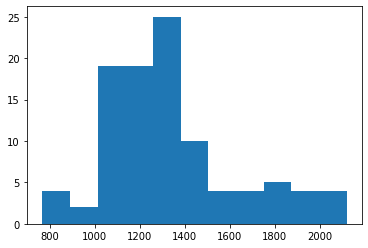

In [ ]:
return_histo(eval_env, collect_policy, num_episodes=100)


In [ ]:
import tensorflow_probability as tfp
time_step=eval_env.reset()
found=False
while not found:
  for i in range(1400):
    if i>1000:
      found=True
      action_distr=collect_policy.action(time_step)
      logits=action_distr[2]['dist_params']['logits'][0]
      print('Time step:', i, 'Action probabilities:',tf.nn.softmax(logits).numpy())
    if time_step.is_last():
      print('Episode ended with {} time steps'.format(i))
      break
    action=PPO_agent.policy.action(time_step)
    time_step=eval_env.step(action)


Time step: 1001 Action probabilities: [1.0018376e-04 3.7501833e-01 6.2482345e-01 1.4659676e-05 3.1235762e-05
 1.2161124e-05]
Time step: 1002 Action probabilities: [8.12846847e-05 3.77406329e-01 6.22468710e-01 1.07296855e-05
 2.39002748e-05 9.02924603e-06]
Time step: 1003 Action probabilities: [7.8857316e-05 3.7784448e-01 6.2203473e-01 1.0233347e-05 2.3054166e-05
 8.6208029e-06]
Time step: 1004 Action probabilities: [9.3567141e-05 3.7752926e-01 6.2232465e-01 1.2789008e-05 2.8972980e-05
 1.0802051e-05]
Time step: 1005 Action probabilities: [9.3274284e-05 3.7933737e-01 6.2051648e-01 1.3399760e-05 2.8334118e-05
 1.1220204e-05]
Time step: 1006 Action probabilities: [8.80829903e-05 3.79508555e-01 6.20354533e-01 1.23506115e-05
 2.62112571e-05 1.03730972e-05]
Time step: 1007 Action probabilities: [8.7323846e-05 3.7875137e-01 6.2111324e-01 1.2150552e-05 2.5695159e-05
 1.0192084e-05]
Time step: 1008 Action probabilities: [0.08975118 0.18412033 0.25727716 0.02043215 0.3731855  0.07523369]
Time st

In [ ]:
from tf_agents.policies import policy_saver

policy_dir='/content/drive/MyDrive/Reinforcement learning/PPO/Saved Policy'
Policy_saver=policy_saver.PolicySaver(PPO_agent.collect_policy)
Policy_saver.save(policy_dir)